Episode 0: -190472.14947306103
Episode 1: -160523.49760161623
Episode 2: -180478.02464112482
Episode 3: -170422.285224123
Episode 4: -170488.20612176834
Episode 5: -200500.04774019966
Episode 6: -200481.31373824656
Episode 7: -210482.2822685628
Episode 8: -210484.86241032853
Episode 9: -210478.9924164965
Episode 10: -220383.13391272983
Episode 11: -190475.5708772923
Episode 12: -200436.96709321972
Episode 13: -220476.58335190304
Episode 14: -220424.5846827611
Episode 15: -180490.31520069213
Episode 16: -170537.30728864568
Episode 17: -190524.07947318195
Episode 18: -190498.40577110767
Episode 19: -190501.07138827146
Episode 20: -200406.1151526353
Episode 21: -170517.07188419005
Episode 22: -170465.68114704126
Episode 23: -180430.2846695713
Episode 24: -160553.8185536361
Episode 25: -180513.72813515694
Episode 26: -200454.02816343907
Episode 27: -190524.9131641064
Episode 28: -200422.25971682783
Episode 29: -160481.16038409894
Episode 30: -200436.3722606147
Episode 31: -190489.584054815

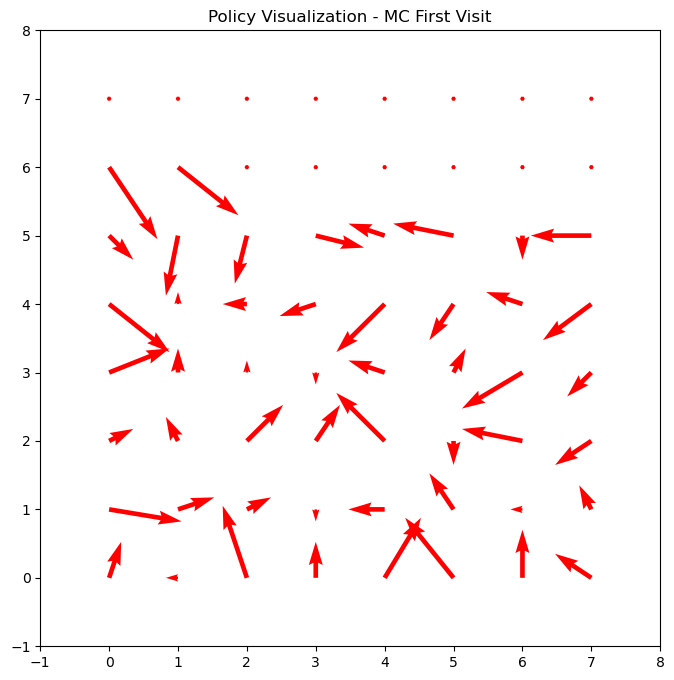

Optimal Q-Values (MC Every Visit):  [[-119492.68626364 -113312.05710068 -120296.89889606 ... -119101.56717832
  -116964.53657858 -117695.5995605 ]
 [ -94819.60573881 -102735.36964224  -98116.47217271 ...  -98776.10427462
   -95750.97313763  -99010.94645163]
 [ -99490.10041596  -97928.45694173 -103317.96513267 ...  -98734.64512699
  -105067.0299988   -97744.34341876]
 ...
 [ -98600.95882302  -99408.00652832 -101877.86158137 ... -108292.33128111
   -96502.37732277 -101029.83495775]
 [ -97158.14866303  -97698.75265309  -97327.47749333 ...  -97999.04804964
  -101330.12220514  -99523.76651588]
 [-101886.59906491  -94280.02007683  -95195.84596493 ...  -97842.96004327
  -100307.14194494 -104094.38511075]]
Optimal Policy (MC Every Visit):  [31 32 19 18 35 31 35 48 16 11 33  8 35 34 15 47 31 32 40 25 46 12  6 43
 42  8 29  0 23 48 31 45 30  7 49  7 32 31 32 38 27 29 22 34  2  5  1 42
 27  1]


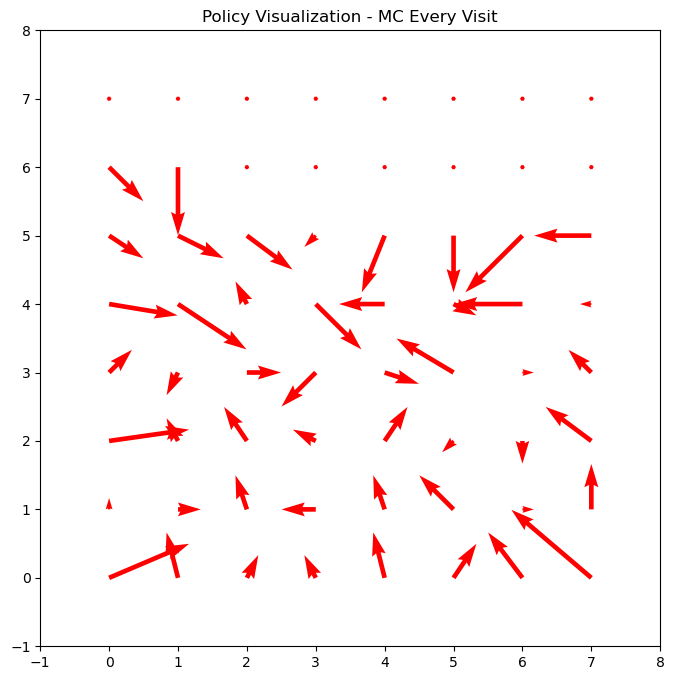

In [3]:
from typing import Dict, List, Optional, Tuple, Any
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

class TSPEnvironment(gym.Env):
    """TSP RL environment using Monte Carlo methods."""

    def __init__(self, num_targets: int, max_area: int = 30, seed: int = None) -> None:
        super().__init__()
        if seed is not None:
            np.random.seed(seed)

        self.steps = 0
        self.num_targets = num_targets
        self.max_steps = num_targets
        self.max_area = max_area
        self.locations = self._create_random_points(num_targets)
        self.distance_matrix = self._compute_distance_matrix(self.locations)

        # Define observation and action spaces
        self.observation_space = gym.spaces.Box(
            low=np.array([0] + [0] * num_targets + [0] * (2 * num_targets), dtype=np.float32),
            high=np.array([num_targets] + [2 * max_area] * num_targets + [max_area] * (2 * num_targets), dtype=np.float32)
        )
        self.action_space = gym.spaces.Discrete(num_targets)

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None) -> Tuple[np.ndarray, Dict[str, Any]]:
        self.steps = 0
        self.current_location = 0
        self.visited_targets = []
        state = self._get_current_state()
        return state, {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, Any]]:
        self.steps += 1
        previous_location = self.current_location
        self.current_location = action
        reward = self._calculate_reward(previous_location, action)
        self.visited_targets.append(action)
        done = self.steps >= self.max_steps
        next_state = self._get_current_state()
        return next_state, reward, done, False, {}

    def _create_random_points(self, count: int) -> np.ndarray:
        return np.random.rand(count, 2) * self.max_area

    def _compute_distance_matrix(self, points: np.ndarray) -> np.ndarray:
        return np.linalg.norm(points[:, None] - points[None, :], axis=2)

    def _calculate_reward(self, from_loc: int, to_loc: int) -> float:
        if to_loc not in self.visited_targets:
            return -self.distance_matrix[from_loc, to_loc]
        return -10000  # Penalty for revisiting

    def _get_current_state(self) -> np.ndarray:
        distances = self.distance_matrix[self.current_location]
        return np.concatenate([np.array([self.current_location]), distances, self.locations.flatten()])

    def monte_carlo(self, num_episodes: int = 10000, gamma: float = 0.99, first_visit: bool = True) -> Tuple[np.ndarray, np.ndarray]:
        Q = np.zeros((self.num_targets, self.num_targets))
        returns_count = np.zeros((self.num_targets, self.num_targets))

        for _ in range(num_episodes):
            state, _ = self.reset()
            episode = []

            for _ in range(self.max_steps):
                action = self.action_space.sample()  # Random action
                next_state, reward, terminated, _, _ = self.step(action)
                episode.append((int(state[0]), action, reward))
                state = next_state
                if terminated:
                    break

            G = 0
            visited = set()
            for state, action, reward in reversed(episode):
                G = reward + gamma * G
                if first_visit:
                    if (state, action) not in visited:
                        returns_count[state, action] += 1
                        Q[state, action] += (G - Q[state, action]) / returns_count[state, action]
                        visited.add((state, action))
                else:
                    returns_count[state, action] += 1
                    Q[state, action] += (G - Q[state, action]) / returns_count[state, action]

        policy = np.argmax(Q, axis=1)
        return Q, policy

    def visualize_policy(self, policy: np.ndarray, title: str = "Policy Visualization"):
        grid_size = int(np.ceil(np.sqrt(self.num_targets)))
        X, Y = np.meshgrid(np.arange(grid_size), np.arange(grid_size))

        U = np.zeros_like(X, dtype=float)
        V = np.zeros_like(Y, dtype=float)

        for i in range(self.num_targets):
            row, col = divmod(i, grid_size)
            next_target = policy[i]
            next_row, next_col = divmod(next_target, grid_size)

            U[row, col] = next_col - col
            V[row, col] = next_row - row

        plt.figure(figsize=(8, 8))
        plt.quiver(X, Y, U, V, angles='xy', scale_units='xy', color='r')
        plt.xlim(-1, grid_size)
        plt.ylim(-1, grid_size)
        plt.title(title)
        plt.show()


if __name__ == "__main__":
    num_targets = 50
    env = TSPEnvironment(num_targets)

    episode_returns = []
    for episode in range(100):
        total_reward = 0
        observation = env.reset()[0]
        for _ in range(100):
            action = env.action_space.sample()  # Random action for exploration
            next_observation, reward, done, _, _ = env.step(action)
            total_reward += reward
            if done:
                break

        episode_returns.append(total_reward)
        print(f"Episode {episode}: {total_reward}")

    print(f"Average Return over 100 episodes: {np.mean(episode_returns)}")

    # Monte Carlo First-Visit
    Q_first_visit, policy_first_visit = env.monte_carlo(first_visit=True)
    print("Optimal Q-Values (MC First Visit): ", Q_first_visit)
    print("Optimal Policy (MC First Visit): ", policy_first_visit)
    env.visualize_policy(policy_first_visit, title="Policy Visualization - MC First Visit")

    # Monte Carlo Every-Visit
    Q_every_visit, policy_every_visit = env.monte_carlo(first_visit=False)
    print("Optimal Q-Values (MC Every Visit): ", Q_every_visit)
    print("Optimal Policy (MC Every Visit): ", policy_every_visit)
    env.visualize_policy(policy_every_visit, title="Policy Visualization - MC Every Visit")
